In [ ]:
# default_exp keras_callbacks

# Keras Callbacks

> Custom callbacks for tensorflow.keras.

In [ ]:
# export
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from operator import gt, lt
import os
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping,
    ModelCheckpoint, TensorBoard, LambdaCallback)
import warnings
import math
import os

In [ ]:
%matplotlib inline

In [ ]:
# export
class CosineLRScheduler(Callback):
    """```Learning rate scheduler that makes updates each batch. Built-in
    Keras version only updates once per epoch.
    ```"""

    def __init__(self, max_lr, epochs, iters_per_epoch, warm=0.3,
                 restarts=False, cycle_len=5, cycle_decay=0.0, min_lr=None,
                 verbose=False):
        """```
        Parameters
        ----------
        max_lr: float
            Maximum learning rate to use during training.
        epochs: int
            Number of epochs to train for.
        iters_per_epoch: int
            Number of batches in each epoch.
        warm: float
            Percent of training run (or cycle length) devoted to the increasing
            portion of the schedule. Default 0.3.
        restarts: bool
            Specifies whether to use restarts, i.e. use a cyclical LR.
            True: Version of cosine annealing with restarts. In one
                  cycle, LR starts high and gradually decreases.
                  At the start of the next cycle, it is
                  immediately increased again.
            False: Version of cosine annealing where LR increases
                   for first 30% of training, then decreases for
                   remaining 70%.
        cycle_len: int
            Number of epochs contained in a single cycle. Only used
            when scheduler uses restarts.
        cycle_decay: float
            Scalar to decay the learning rate at the end of each cycle.
            This is only used with restarts, since the regular cosine
            annealing already decays the LR over time.
            E.g. 1.0 will use no decay.
            0.9 means that cycle 2 LRs = cycle 1 LRs * 0.9,
            cycle 3 LRs = cycle 1 LRs * .81,
            etc.
        min_lr: float
            Minimum learning rate. If None is specified, it will be set
            to max_lr / 25.
        ```"""
        super().__init__()
        self.max_lr = max_lr
        self.min_lr = min_lr or max_lr / 25
        self.epochs = epochs
        self.iters_per_epoch = iters_per_epoch
        self.iters = epochs * iters_per_epoch
        self.warm = warm

        if restarts and cycle_len < self.iters:
            warnings.warn('Training will consist of less than 1 full cycle.')

        self.cycle_len = cycle_len
        self.cycle_decay = cycle_decay
        self.restarts = restarts
        self.lrs = self._schedule(restarts)
        self.curr_iter = 0
        self.verbose = verbose

    def on_batch_begin(self, batch, logs=None):
        """Update learning rate based on current iteration."""
        if self.verbose:
            print(f'\nUpdate LR from {self.model.optimizer.lr.numpy():.3E}',
                  end='')

        # Continue using min_lr if training past specified max iters.
        try:
            lr = self.lrs[self.curr_iter]
        except IndexError:
            lr = self.lrs[-1]
        K.set_value(self.model.optimizer.lr, lr)

        self.curr_iter += 1
        if self.verbose:
            print(f' to {self.model.optimizer.lr.numpy():.3E}')

    @staticmethod
    def _cosine_anneal(iters, lr1, lr2):
        """Helper function for _cosine_tri_lr().

        Parameters
        ----------
        iters: int
            Number of iterations in segment.
        lr1: float
            Learning rate at start of segment.
        lr2: float
            Learning rate at end of segment.

        Returns
        -------
        np.array
        """
        i = np.arange(iters)
        return lr2 + (lr1 - lr2)*(1 + np.cos(np.pi * i/iters))/2

    def _cosine_schedule(self):
        """Cosine annealing scheduler. Computes learning rates for each
        iteration.

        Returns
        -------
        np.array
        """
        seg1 = self._cosine_anneal(int(self.warm * self.iters),
                                   self.min_lr,
                                   self.max_lr)
        seg2 = self._cosine_anneal(int(np.ceil((1 - self.warm) * self.iters)),
                                   self.max_lr,
                                   self.min_lr)
        return np.concatenate((seg1, seg2))

    def _cosine_restarts_schedule(self):
        """Cosine annealing with restarts."""
        cycles = int(np.ceil(self.iters /
                             (self.cycle_len * self.iters_per_epoch)))
        cycle_iters = self.cycle_len * self.iters_per_epoch
        lrs = [self._cosine_anneal(cycle_iters, self.max_lr, self.min_lr)
               / (1 + self.cycle_decay * i) for i in range(cycles)]
        return np.concatenate(lrs)

    def _schedule(self, restarts):
        """Wrapper to schedule learning rates depending on chosen method.

        Parameters
        ----------
        restarts: bool
            If True, use schedule with restarts. If False, use regular
            cosine annealing that spans whole duration of training.

        Returns
        -------
        np.array: LR for each iteration (i.e. output[i] is the LR to use
            at iteration i).
        """
        if restarts:
            return self._cosine_restarts_schedule()
        return self._cosine_schedule()

    def plot_lrs(self, path=None):
        """Display learning rate by iteration.

        Note: If the plot is not as smooth as expected, this likely
        means that there are very few iterations per epoch
        (i.e. the batch size is very large, at least in relative terms).
        """
        plt.plot(self.lrs)
        plt.xlabel('Iteration')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        if path:
            plt.savefig(path)
            plt.close()
        else:
            plt.show()

    def reset(self):
        """Reset the current iteration to zero. Note that if the learning rate
        has been decayed, it will now be back at the initial value.
        """
        self.curr_iter = 0

    def __repr__(self):
        return (f'CosineLRScheduler(max_lr={self.max_lr}, '
                f'epochs={self.epochs}, '
                f'iters_per_epoch={self.iters_per_epoch}, '
                f'restarts={self.restarts}, '
                f'cycle_len={self.cycle_len}, '
                f'min_lr={self.min_lr}, '
                f'verbose={self.verbose})')

In [ ]:
# export
class BatchHistory(Callback):
    """```Callback to store training loss at each mini batch. Built in
    history callback only stores epoch losses. Validation set is only
    evaluated at the end of each epoch so it's not included here.
    ```"""

    def __init__(self, path=None):
        super().__init__()
        self.path = path
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        self.losses.append(logs.get('loss'))

    def on_train_end(self, logs=None):
        if self.path:
            with open(self.path, 'a') as f:
                f.write('\n'.join(str(loss) for loss in self.losses) + '\n')

    def plot_batch_losses(self, path=None, smooth=50):
        smoothed = [np.mean(self.losses[i:i+smooth])
                    for i in range(len(self.losses))]

        plt.plot(self.losses, lw=.5, c='blue', alpha=.25, label='Batch Losses')
        plt.plot(smoothed, lw=.5, c='blue', alpha=1, label='Smoothed Losses')
        plt.xlabel('Iteration')
        plt.ylabel('Training Loss')
        plt.title('Training Loss by Mini Batch.')
        plt.legend()
        if path:
            plt.savefig(path)
            plt.close()
        else:
            plt.show()

In [ ]:
# export
class PerformanceThreshold(Callback):
    """Callback that will stop training if performance falls short of
    some user-specified threshold. This can help avoid wasting time on
    runs that have clearly gone wrong - e.g. learning rate is too large
    and validation BCE loss has ballooned to >2.0 on a balanced dataset.
    """

    def __init__(self, metric='val_loss', threshold=1.0, goal='min'):
        """```
        Parameters
        ----------
        metric: str
            Name of metric to monitor.
        threshold: float
            Performance threshold. If the quantity being monitored is
            something we want to minimize, this is the highest
            acceptable value to continue training. If it's a metric to
            maximize like accuracy, this is the minimum acceptable
            value.
        goal: str
            Goal of the quantity being monitored (i.e. are we trying to
            minimize metric or maximize it?). One of ('max', 'min').
        ```"""
        super().__init__()
        assert goal in ('max', 'min')

        self.metric = metric
        self.threshold = threshold
        if goal == 'max':
            self.op = gt
        elif goal == 'min':
            self.op = lt

    def on_epoch_end(self, batch, logs=None):
        curr_val = logs.get(self.metric)
        if curr_val is not None and self.op(self.threshold, curr_val):
            print(f'{self.metric} of {curr_val:.3e} did not satisfy '
                  f'performance threshold of {self.threshold}. '
                   'Stopping training.')
            self.model.stop_training = True

In [ ]:
# export
class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0

    The following code is attributed to https://github.com/surmenok/keras_lr_finder
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.learning_rate)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 3):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.learning_rate, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.learning_rate)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.learning_rate, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')
        os.remove('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.learning_rate, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.learning_rate)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.learning_rate, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')
        os.remove('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.learning_rate, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])[0]
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

Below, the callbacks are shown on a dummy MNIST model.

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, ReLU, Input, Flatten, GlobalMaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
(X_train, y_train),(X_test, y_test) = mnist.load_data()
X_train, X_test = np.expand_dims(X_train/255., -1), np.expand_dims(X_test/255., -1)

In [ ]:
model = Sequential([
    Input(X_train.shape[1:]),
    Conv2D(24, (3,3), padding='same'),
    ReLU(),
    BatchNormalization(),
    GlobalMaxPool2D(),
    Flatten(),
    Dense(10, activation='softmax')
])

model.compile(loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
BS = 64
EPOCHS = 1
STEPS_PER_EPOCH = np.ceil(X_train.shape[0]/BS)

In [ ]:
lr_finder = LRFinder(model)

In [ ]:
lr_finder.find(X_train, y_train, start_lr=1e-6, end_lr=1e-1, batch_size=BS)

Train on 60000 samples
60000/60000 [==============================] - 15s 245us/sample - loss: 4.6301 - accuracy: 0.1604


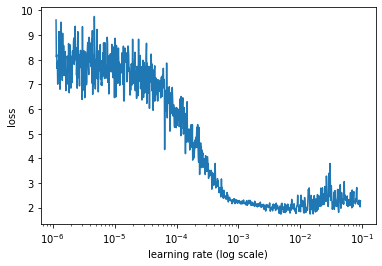

In [ ]:
lr_finder.plot_loss()

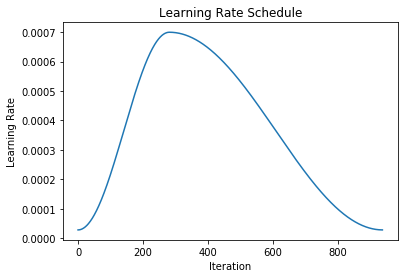

In [ ]:
scheduler = CosineLRScheduler(7e-4, EPOCHS, STEPS_PER_EPOCH)
bh = BatchHistory()
scheduler.plot_lrs()

In [ ]:
model.fit(X_train, y_train, batch_size=BS, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[scheduler, bh])

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 13s 220us/sample - loss: 2.7387 - accuracy: 0.2568 - val_loss: 1.8717 - val_accuracy: 0.3534


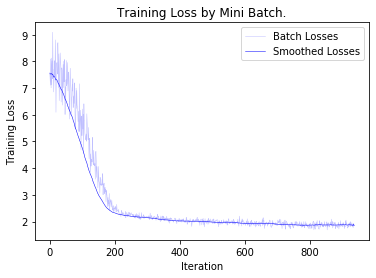

In [ ]:
bh.plot_batch_losses()